# Test model mismatch hypothesis on IBL task

## Summary

In this notebook, we use synthetic data sampled from the IBL task to investigate whether an agent implementing Bayesian filtering with an underestimate of the true hazard rate of the task inputs ("model mismatch") could produce behavior consistent with the GLM-HMM model used by Ashwood et al., 2020. To do this we:
  1. Sample synthetic task data where block values (and therefore stimulus sides at different times) are completely uncorrelated ($H=0.5$)
  2. Run Bayesian filtering agent that assumes level of time correlation used for biased section of session ($H = 0.02$) on task data to create synthetic behavioral data
  3. Fit GLM-HMM model to generated behavioral data
  4. Examine fit values of GLM parameters for different states and correlations between most likely state sequence and prior values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

from numpy.random import default_rng
from scipy.special import logit, expit
from ssm.util import find_permutation

from tasks import IBLTask
from iblmodel import IBLAgent, IBLModel

In [2]:
rng = default_rng(999)

## Create synthetic data with uncorrelated stimuli

In [3]:
# Number of trials to sample
n_trials = 8000

# Hazard rate of 0.5 reduces IBL task to Bernoulli process
h_true = 0.5

# Gaussian noise added to stimulus for observation
noise_true = 1.0

# Side probability
a_true = 0.8

task = IBLTask(hazard_rate=h_true, noise=noise_true, alpha=a_true, rng=rng)
b, s, x = task.sample_trials(n_trials)

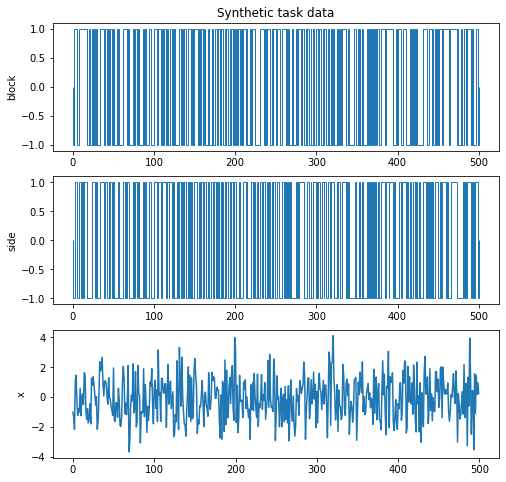

In [4]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(3, 1, figsize=(8, 8))

ax[0].stairs(b[idx])
ax[0].set_ylabel('block')

ax[1].stairs(s[idx])
ax[1].set_ylabel('side')

ax[2].plot(x[idx])
ax[2].set_ylabel('x')

ax[0].set_title('Synthetic task data');

## Run Bayesian filtering agent with underestimated hazard rate on data

In [5]:
# Incorrect value for hazard rate
h_agent = 0.001

# Optimal values for bias and weight
w0_true = 0
w1_true = 2 / (noise_true ** 2)

# Create agent with incorrect hazard rate and otherwise optimal parameters
agent = IBLAgent(h=h_agent, a=a_true, w_0=w0_true, w_1=w1_true, rng=rng)

# Choice samples and decision function values
y, r, q = agent.sample(x, s, return_rq=True)

# Compute choice probability from decision function
p = expit(r)

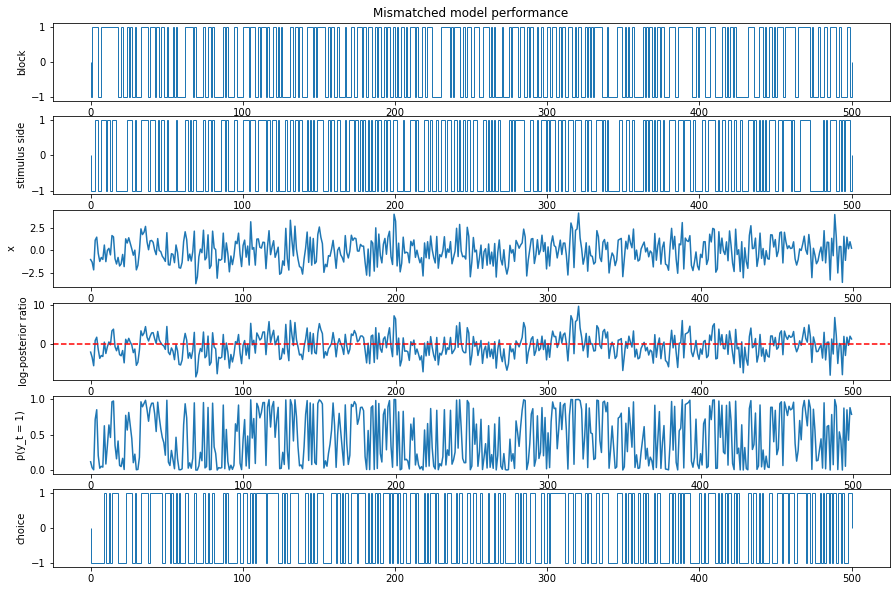

In [6]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(6, 1, figsize=(15, 10))

ax[0].stairs(b[idx])
ax[0].set_ylabel('block')

ax[1].stairs(s[idx])
ax[1].set_ylabel('stimulus side')

ax[2].plot(x[idx])
ax[2].set_ylabel('x')

ax[3].plot(r[idx])
ax[3].axhline(y=0, color='r', linestyle='--')
ax[3].set_ylabel('log-posterior ratio')

ax[4].plot(p[idx])
ax[4].set_ylabel('p(y_t = 1)')

ax[5].stairs(y[idx])
ax[5].set_ylabel('choice')

ax[0].set_title('Mismatched model performance');

### Sanity check: Recover model parameters from behavioral data

In [7]:
# Fit model to preductions from optimal model
model = IBLModel()
model.fit(x, s, y)

# Print parameters of fit model
print('hazard rate (h):')
print(f'    model: {model.h:.3f}    agent: {agent.h:.3f}')
print('side probability (a):')
print(f'    model: {model.a:.3f}    agent: {agent.a:.3f}')
print('bias (w_0):')
print(f'    model: {model.w_0:.3f}    agent: {agent.w_0:.3f}')
print('coef (w_1):')
print(f'    model: {model.w_1:.3f}    agent: {agent.w_1:.3f}')

hazard rate (h):
    model: 0.001    agent: 0.001
side probability (a):
    model: 0.204    agent: 0.800
bias (w_0):
    model: -0.008    agent: 0.000
coef (w_1):
    model: 2.003    agent: 2.000


## Fit GLM-HMM to synthetic behavioral data

### Create GLM-HMM and fit to data

In [8]:
# Modify inputs for GLM-HMM (need to add column of ones)
x_mod = np.ones((x.shape[0], 2))
x_mod[:, 0] = x

# Modify choices for GLM-HMM (y=1 maps to y=0 and y=-1 maps to y=1)
y_mod = np.reshape(y, (-1, 1))
y_mod = (1 - y_mod) / 2
y_mod = y_mod.astype(np.int64)

In [9]:
# Set the parameters of the GLM-HMM
num_states = 3
obs_dim = 1
num_categories = 2
input_dim = 2

# Create GLM-HMM
glm_hmm = ssm.HMM(
    num_states, 
    obs_dim, 
    input_dim, 
    observations="input_driven_obs", 
    observation_kwargs=dict(C=num_categories), 
    transitions="standard"
)

In [10]:
# Number of EM iterations
n_iter = 200

# Fit model
glm_hmm_fit = glm_hmm.fit(
    [y_mod], 
    inputs=[x_mod], 
    method="em", 
    num_iters=n_iter, 
    tolerance=10**-4
)

LP: -3078.9: 100%|██████████| 200/200 [00:10<00:00, 19.50it/s]


### State parameters

In [11]:
params = glm_hmm.observations.params
coef_vals = [params[k][0][0] for k in range(3)]
bias_vals = [params[k][0][1] for k in range(3)]

print('state 0:')
print(f'    coef: {coef_vals[0]:.3f}    bias: {bias_vals[0]:.3f}')
print('state 1:')
print(f'    coef: {coef_vals[1]:.3f}    bias: {bias_vals[1]:.3f}')
print('state 2:')
print(f'    coef: {coef_vals[2]:.3f}    bias: {bias_vals[2]:.3f}')

state 0:
    coef: 1.879    bias: 0.985
state 1:
    coef: 1.786    bias: -0.777
state 2:
    coef: 2.700    bias: -2.047


### Compute most likely state sequence and corresponding bias values

In [12]:
est_states = glm_hmm.most_likely_states(y_mod, input=x_mod)
est_bias = [bias_vals[k] for k in est_states]

### Plot estimated bias value against decision function

Text(0, 0.5, 'GLM-HMM bias')

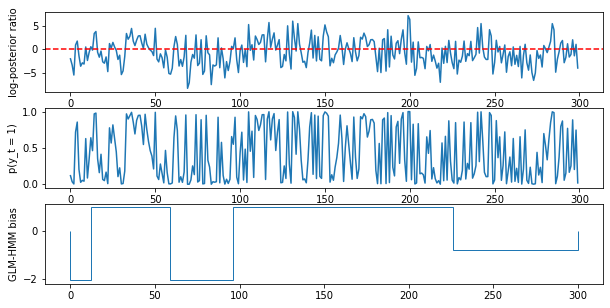

In [13]:
idx = np.s_[0:300]

(fig, ax) = plt.subplots(3, 1, figsize=(10, 5))

ax[0].plot(r[idx])
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_ylabel('log-posterior ratio')

ax[1].plot(p[idx])
ax[1].set_ylabel('p(y_t = 1)')

ax[2].stairs(est_bias[idx])
ax[2].set_ylabel('GLM-HMM bias')

In [14]:
p_corr = np.corrcoef(p, est_bias)[0, 1]
print(f'correlation: {p_corr}')

correlation: 0.2450519805528348


### Plot estimated bias against prior

In [15]:
# Compute prior from decision function
def phi(a, b):
    return np.logaddexp(0, a + b) - np.logaddexp(a, b)

r_prev = np.zeros(r.shape)
r_prev[1:] = r[:-1]
prior = phi(r_prev, logit(1 - h_agent))

Text(0, 0.5, 'GLM-HMM bias')

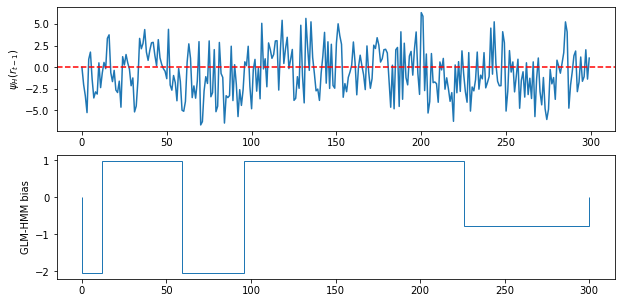

In [16]:
idx = np.s_[0:300]

(fig, ax) = plt.subplots(2, 1, figsize=(10, 5))

ax[0].plot(prior[idx])
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_ylabel('$\psi_H(r_{t-1})$')

ax[1].stairs(est_bias[idx])
ax[1].set_ylabel('GLM-HMM bias')

In [17]:
prior_corr = np.corrcoef(prior, est_bias)[0, 1]
print(f'correlation: {prior_corr}')

correlation: 0.25569572780441524
